In [1]:
import os 

OD9_train_path = os.environ["DATA"] + "/00_datasets/DFT/OD9_7/OD9_7_smi_datasets/train_test_dataset_400000.smi"
QM9_train_path = os.environ["DATA"] + "/00_datasets/DFT/QM9/QM9_smi_datasets/train_test_dataset_100000.smi"

OD9_output_path = os.environ["DATA"] + "/00_datasets/DFT/OD9_7/OD9_7_smi_datasets/train_test_dataset_low_HOMO_median.smi"
QM9_output_path = os.environ["DATA"] + "/00_datasets/DFT/QM9/QM9_smi_datasets/train_test_dataset_low_HOMO_median.smi"

OD9_json_cache_location = os.environ["DATA"] + "/00_datasets/DFT/cache_OD9_step7.json"
QM9_json_cache_location = os.environ["DATA"] + "/00_datasets/DFT/QM9/QM9.json"

threshold = -6.35

In [2]:
import csv
from rdkit.Chem import MolFromSmiles, MolToSmiles
from tqdm import tqdm


def extract_smiles(path):
    
    smiles_list = []
    
    with open(path, "r") as f:
        reader = csv.reader(f)
        for row in tqdm(list(reader)):
            smiles_list.append(row[0].rstrip())
            
    return smiles_list

In [3]:
from bbo.objective import EvoMolEvaluationStrategyWrapper
from evomol.evomol.evaluation_dft import OPTEvaluationStrategy

def compute_HOMO(smiles_list):
    objective = EvoMolEvaluationStrategyWrapper(OPTEvaluationStrategy("homo", n_jobs=2, 
                                                                      cache_files=[OD9_json_cache_location, 
                                                                                   QM9_json_cache_location],
                          working_dir_path="/home/jleguy/dft_comput", MM_program="rdkit"), n_jobs=1)
    
    homo_values, all_scores, success = objective.fit_transform(smiles_list)
    return homo_values

In [4]:
OD9_smiles = extract_smiles(OD9_train_path)
QM9_smiles = extract_smiles(QM9_train_path)

100%|██████████| 100000/100000 [00:00<00:00, 3199389.76it/s]


In [5]:
OD9_HOMO = compute_HOMO(OD9_smiles)
QM9_HOMO = compute_HOMO(QM9_smiles)

445764 molecules in cache
445764 molecules in cache


In [6]:
print(len(OD9_HOMO))
print(len(QM9_HOMO))

400000
100000


In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="ticks", color_codes=True)
import pandas as pd
import numpy as np

from IPython.display import display

def plot_dist(OD9_HOMO, QM9_HOMO):
    
    print("Med OD9 : " + str(np.median(OD9_HOMO)))
    print("Med QM9 : " + str(np.median(QM9_HOMO)))
    
    plt.figure(figsize=(15, 10))
    plt.xlim(-12, 0)
    sns.distplot(OD9_HOMO, label="OD9")
    sns.distplot(QM9_HOMO, label="QM9")
    plt.axvline(threshold)
    plt.legend()
    plt.show()

Med OD9 : -6.188062839800001
Med QM9 : -6.3495897102


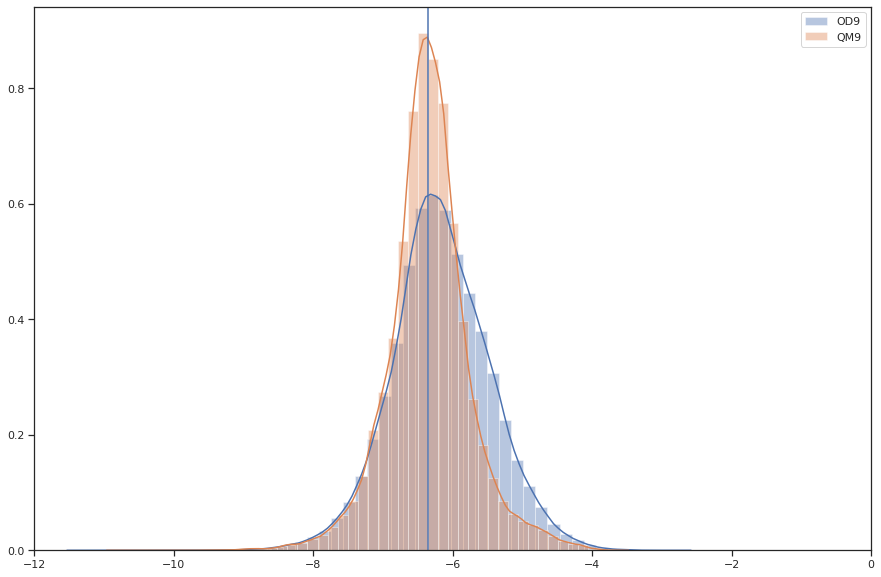

In [8]:
plot_dist(OD9_HOMO, QM9_HOMO)

In [9]:
def filter_homo_above_threshold(smiles, homo_values, threshold, output_path):
    
    smiles = np.array(smiles)
    homo_values = np.array(homo_values)
    
    smiles_filtered = smiles[homo_values <= threshold]
    homo_filtered = homo_values[homo_values <= threshold]
    
    with open(output_path, "w") as f:
        writer = csv.writer(f)
        for smi in smiles_filtered:
            writer.writerow([smi])
                
    return smiles_filtered, homo_filtered

In [10]:
OD9_smiles_filtered, OD9_HOMO_filtered = filter_homo_above_threshold(OD9_smiles, OD9_HOMO, threshold, 
                                                                     output_path=OD9_output_path)

QM9_smiles_filtered, QM9_HOMO_filtered = filter_homo_above_threshold(QM9_smiles, QM9_HOMO, threshold, 
                                                                     output_path=QM9_output_path)

Med OD9 : -6.718358603
Med QM9 : -6.6544662358


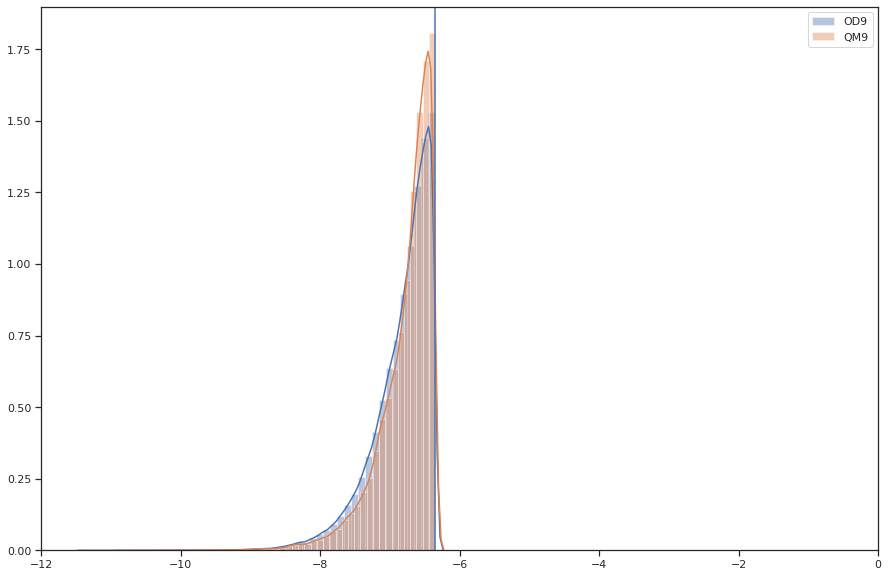

In [11]:
plot_dist(OD9_HOMO_filtered, QM9_HOMO_filtered)

In [12]:
print(len(OD9_smiles_filtered))
print(len(QM9_smiles_filtered))


160125
49952


In [13]:
print(len(np.intersect1d(OD9_smiles, QM9_smiles)))

86751


In [14]:
print(len(np.intersect1d(OD9_smiles_filtered, QM9_smiles_filtered)))

43182
